# ResNet

Когда более глубокая сеть начинает сворачиваться, возникает проблема: с увеличением глубины сети точность сначала увеличивается, а затем быстро ухудшается. Снижение точности обучения показывает, что не все сети легко оптимизировать.



## Shortcut Connection

![-](data/shortcut-connection.png)

Соединения быстрого доступа пропускают один или несколько слоев и выполняют сопоставление идентификаторов. Их выходы добавляются к выходам stacked layers. 

Про такие соединения есть подробный разбор в `notebooks/skewbek/SkipConnection`

## Архитектура ResNet

![-](data/architecture.jpg)

![-](data/architecture2.jpg)

Добавление быстрого соединения, которое превращает сеть в ее остаточную версию. Идентификационные быстрые соединения F(x{W}+x) могут использоваться непосредственно, когда вход и выход имеют одинаковые размерности (быстрые соединения сплошной линии на рис). Когда размерности увеличиваются (пунктирные линии на рис), он рассматривает два варианта:

- Быстрое соединение выполняет сопоставление идентификаторов с дополнительными нулями, добавленными для увеличения размерности. Эта опция не вводит никаких дополнительных параметров.

- Проекция быстрого соединения  в F(x{W}+x) используется для сопоставления размерностей (выполнено с помощью 1×1 сверток).

Такая архитектура совершила революцию в классификации изображения. Поэтому мы постараемся написать ResNet подобную модель. 

Чтобы понять какие изменения мы внесем в нашу модель, давайте выявим различия нашей задачи и задачи ResNet.

- Классов у нас 10. А в ImageNet, датасет для которого был написан resnet, имеет 1000 классов
- Наш датасет имеет размерность изображений (32, 32, 3). В ImageNet нет определенных разменостей, однако большинство картинок имеет примерно размер (500, 400, 3).

# Напишем модель.

In [1]:
import sys
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa
import torchvision as tv
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras

sys.path.append('../../../')

from core.datasets import get_ds
# from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Первый слой resnet это самая большая свертка в моделе и maxpool.

![-](data/step1.jpg)

In [2]:
inputs = tf.keras.Input(shape=(32, 32, 3), batch_size=512)
x = tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same')(inputs)
block1 = tf.keras.layers.MaxPool2D(2)(x)

In [3]:
block1.shape

TensorShape([512, 16, 16, 64])

----
Далее идет первый блок сверток

- свертки размером (3, 3), кол-во фильтров 64

![-](data/step2.jpg)

In [4]:

x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(block1)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)

block2 = tf.keras.layers.add([block1, x])

x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(block2)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)

block3 = tf.keras.layers.add([block2, x])

In [5]:
block3.shape

TensorShape([512, 16, 16, 64])

---
Дальше идет уменьшее размерности изображения вдвое, в кол-во фильтров увеличивается вдвое

![-](data/step3.jpg)

In [6]:

x = tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(block3)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)

block3_conv = tf.keras.layers.Conv2D(128, 1, strides=2, activation='relu')(block3)
block4 = tf.keras.layers.add([x, block3_conv])

x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(block4)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)

block5 = tf.keras.layers.add([block4, x])

x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(block5)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)

block6 = tf.keras.layers.add([block5, x])

In [7]:
block6.shape

TensorShape([512, 8, 8, 128])

----
У нас изображения сильно меньше чем у ImageNet, поэтому добавим третий, последний блок сверток.
Можно заметить, что в блоках, которые стоят по середине слоев больше, поэтому в последнем блоке сделаем столько же слоев, сколько и в первом.

In [8]:
x = tf.keras.layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(block6)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)

block6_conv = tf.keras.layers.Conv2D(256, 1, strides=2, activation='relu')(block6)
block7 = tf.keras.layers.add([x, block6_conv])

x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(block7)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)

block8 = tf.keras.layers.add([block7, x])

In [9]:
block8.shape

TensorShape([512, 4, 4, 256])

----
Осталось применить Global Average Pooling и добавить 10 выходных нейронов.

In [10]:
x = tf.keras.layers.GlobalAveragePooling2D()(block8)
x = tf.keras.layers.Flatten()(block8)
outputs = tf.keras.layers.Dense(10)(x)

In [11]:
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(512, 32, 32, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (512, 32, 32, 64)    4864        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (512, 16, 16, 64)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (512, 16, 16, 64)    36928       ['max_pooling2d[0][0]']          
                                                                                              

## Аугментация

In [12]:
transformer1 = tv.transforms.Compose([
    tv.transforms.RandomInvert(p=0.4),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
])
transformer2 = tv.transforms.Compose([
    tv.transforms.RandomPosterize(bits=6, p=0.4),
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1)),
])
transformer3 = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
])
transformer = [transformer1, transformer2, transformer3]

In [13]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', transform=transformer, one_hot=True, back=3)

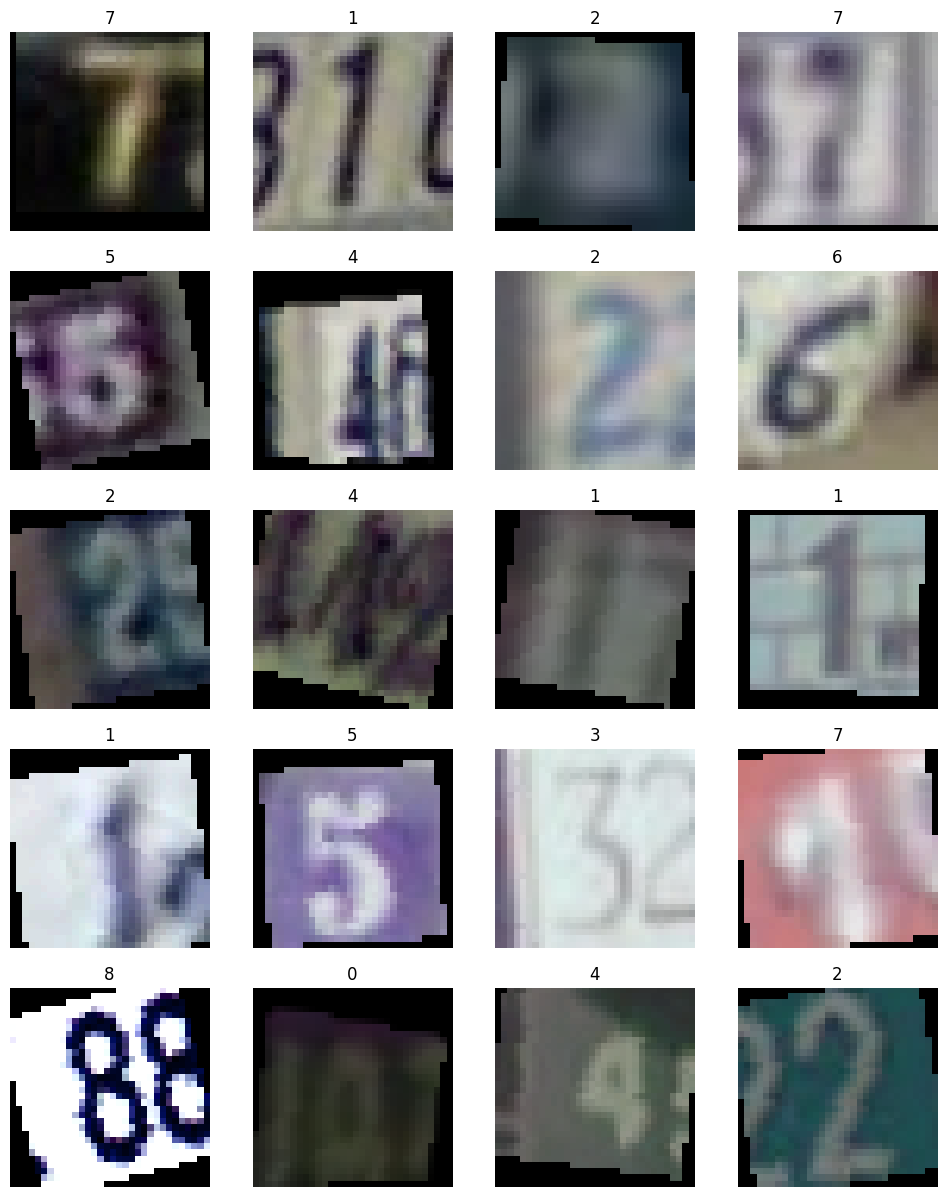

In [14]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

## Чекпоинты

In [15]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
num_model = '_resnet'
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),
]

## Компиляция модели

In [16]:
model.compile(
    optimizer='adam', metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

## Обучение модели

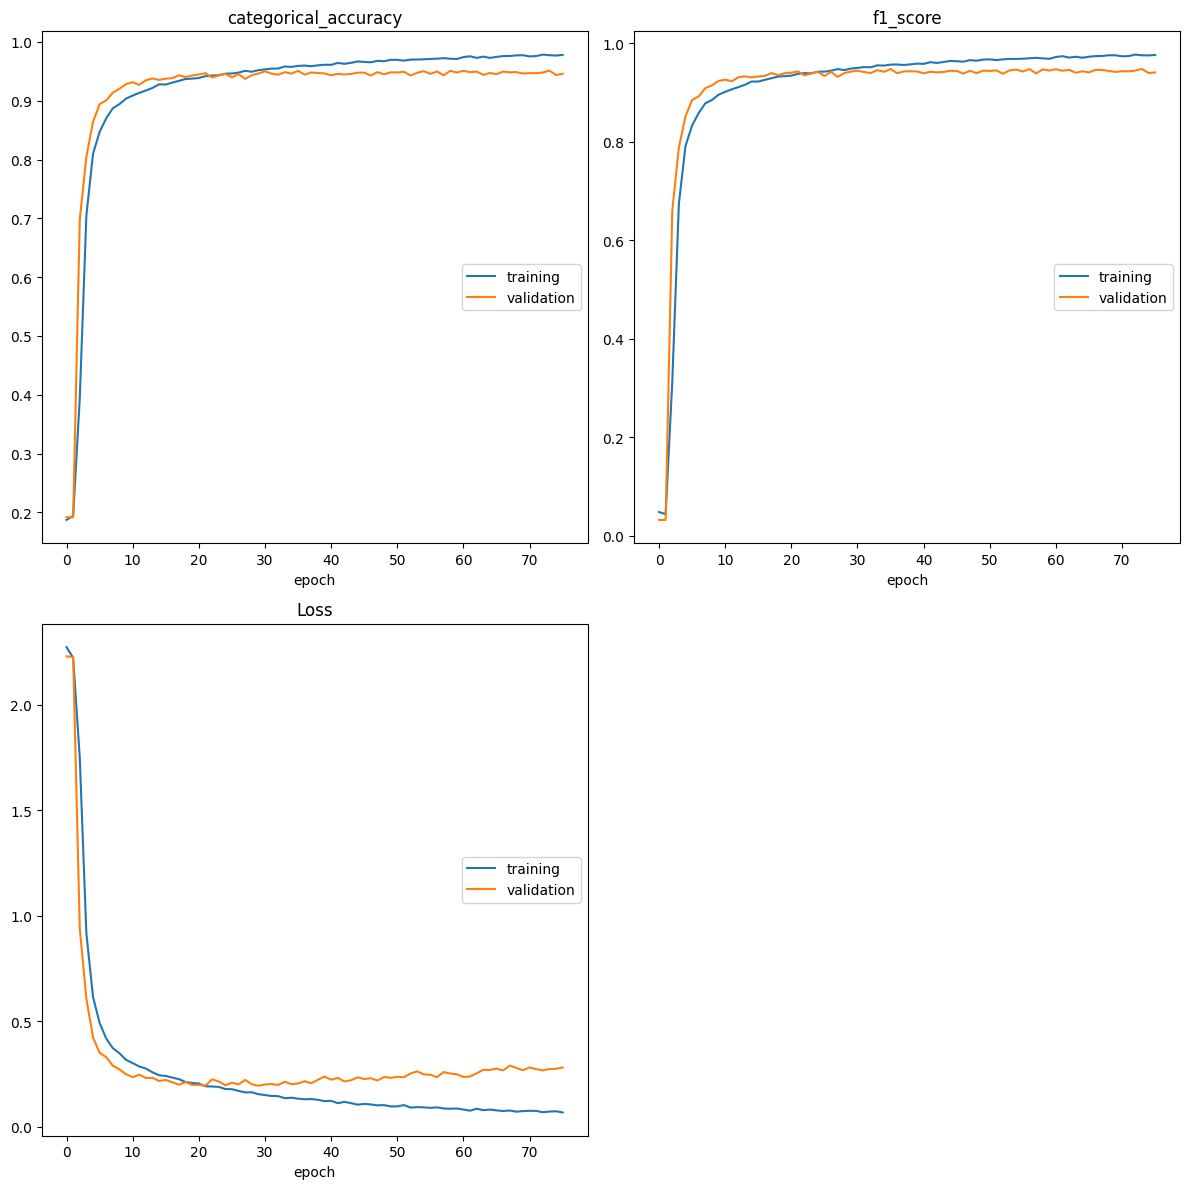

categorical_accuracy
	training         	 (min:    0.187, max:    0.978, cur:    0.978)
	validation       	 (min:    0.192, max:    0.951, cur:    0.946)
f1_score
	training         	 (min:    0.044, max:    0.977, cur:    0.977)
	validation       	 (min:    0.032, max:    0.948, cur:    0.941)
Loss
	training         	 (min:    0.067, max:    2.273, cur:    0.067)
	validation       	 (min:    0.194, max:    2.229, cur:    0.280)


In [17]:
model.fit(train_ds, validation_data=val_ds,
            epochs=100, callbacks=callbacks, verbose=False)